# Homework 5

**Due: 10/22/2020 on gradescope**

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:** Kiara
+ **Last Name:** Koeppen
+ **Email:** kkoeppen@purdue.edu

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as st
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file, putting it in your Google drive, mounting the drive, and changing to the directory of the file (see Problem 0 in [Homework](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/homework/homework_03.ipynb); or
+ Downloading the file to the working directory of this notebook with this code:

In [139]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt'
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [140]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force they marked the stress (force be unit area) in the middle of the materail and the corresponding strain of the material (percent enlogation in the pulling direction).
- Eventually the material entered the plastic regime and then it broke.
Here is a visualization of the data:

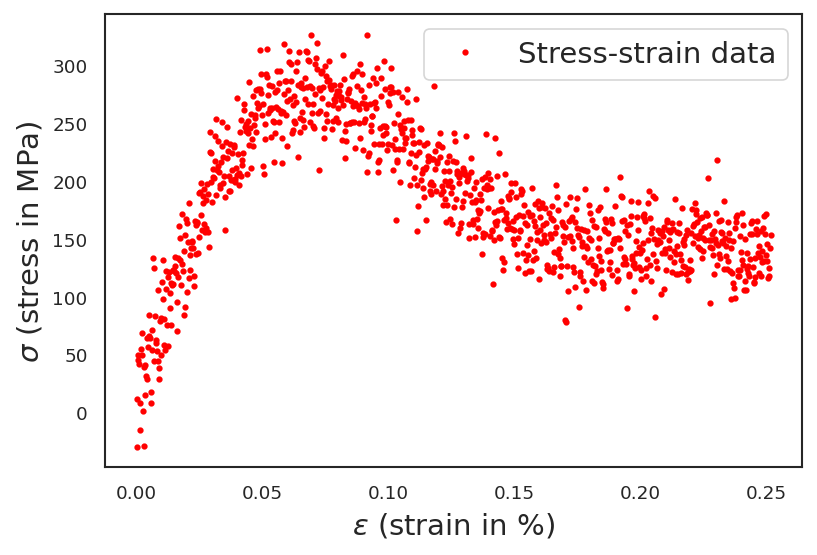

In [141]:
x = data[:, 0] # Strain 
y = data[:, 1] # Stress in MPa
plt.figure(dpi=150)
plt.plot(x, y, 'ro', markersize=2, label = 'Stress-strain data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

Note that for each particular value of the strain, you don't necessarily get a unique stress.
This is because in molecular dynamics the atoms are jiggling around due to thermal effects.
So there is always this "jiggling" noise when you are trying to measure the stress and the strain.
We would like to process this noise in order to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the the material which is affeted by the fine structure, e.g., the chemical bonds, the crystaline structure, any defects, etc.
It is a required input to mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:
$$
\sigma(\epsilon) = E\epsilon.
$$
The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without any noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

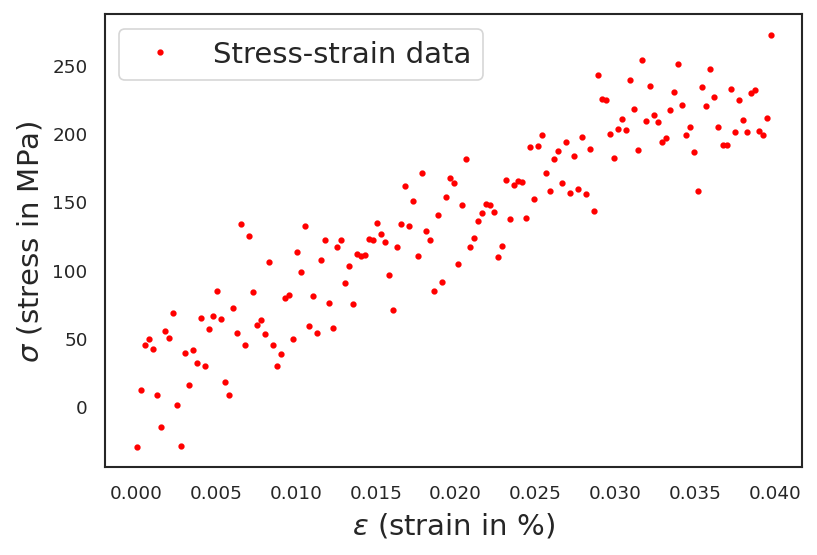

In [142]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]
# Visualize to make sure you have the right data
plt.figure(dpi=150)
plt.plot(x_rel, y_rel, 'ro', markersize=2, label = 'Stress-strain data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

Split your data into training and validation. Hint: You may use [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html](sklearn.model_selection.train_test_split) if you wish.

In [143]:
# Split the data into training and validation datasets
# Hint: Consult the hands-on activities of the lectures

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid=train_test_split(x_rel, y_rel, test_size=0.3)


Use the following to visualize your split:

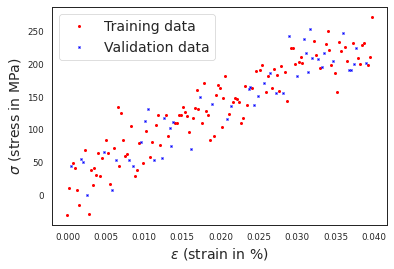

In [144]:
plt.figure()
plt.plot(x_train, y_train, 'ro', markersize=2, label = 'Training data')
plt.plot(x_valid, y_valid, 'bx', markersize=2, label = 'Validation data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [145]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

# Load the Bayesian linear regression class:
from sklearn.linear_model import BayesianRidge
# Select polynomial degree and get design matrix
degree = 1
# Build the design matrix
Phi = get_polynomial_design_matrix(x_rel[:, None], degree)
# Train the model (notice the normalize=True argument)
# Also, the fit_intercept=False is required so that the model does not
# fit a constant offset (the intercept). This is included in our models
# as the first basis function phi_1(x) = 1.
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi, y_rel)

# Sklearn optimizes the precision of the noise which is the inverse of the variance.
# It calls it alpha_.
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))
# Sklearn optimizes the inverse of our alpha (the variance of the weights), which
# it calls lambda_.
alpha = np.sqrt(1.0 / model.lambda_)
print('alpha = {0:1.2f}'.format(alpha))

sigma = 26.66
alpha = 3868.62


### Subpart A.III
Calculate the mean square error of the validation data.

In [146]:
# your code here
# Fit the polynomial model
degree = 1
Phi_poly_train = get_polynomial_design_matrix(x_train[:, None], degree)
w_poly, _, _, _ = np.linalg.lstsq(Phi_poly_train, y_train, rcond=None)
# Make predictions on the validation data
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_valid_predict, y_std = model.predict(Phi_valid, return_std= True)
# Calculate the mean square error
MSE_poly = np.mean((y_valid_predict - y_valid) ** 2)
print('MSE_poly = {0:1.2f}'.format(MSE_poly))


MSE_poly = 694.25


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

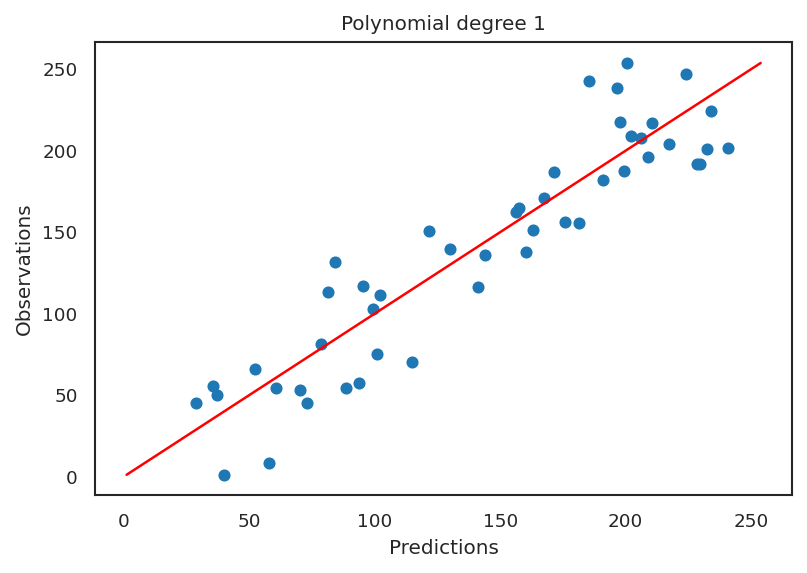

In [147]:
# your code here
# Plot the predictions
xx = np.linspace(0, 0.04, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = np.dot(Phi_poly_xx, w_poly)

# Make predictions on the validation data
Phi_poly_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_valid_predict = np.dot(Phi_poly_valid, w_poly)

# Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');



### Subpart A.V
Compute and plot the standarized errors for the validation data.

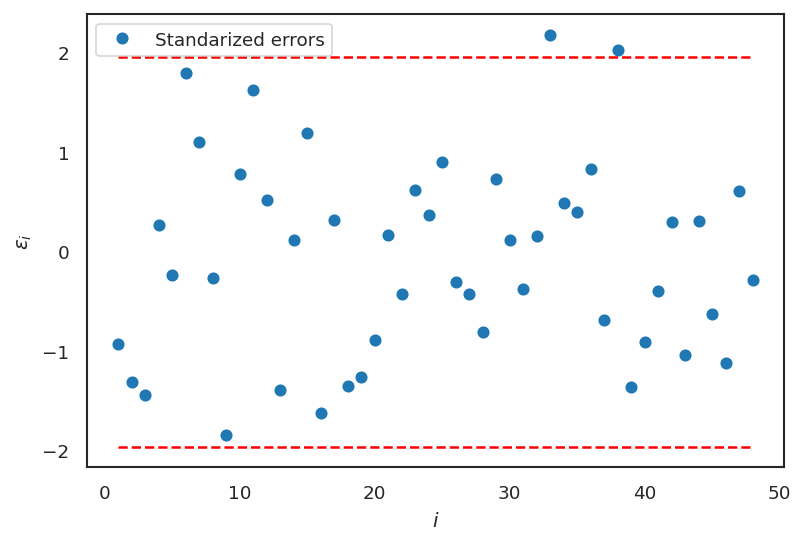

In [149]:
# your code here
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_predict, y_std = model.predict(Phi_valid, return_std=True)
eps = (y_valid - y_predict) / y_std
fig, ax = plt.subplots(dpi=150)
idx = np.arange(1, eps.shape[0] + 1)
# The standarized errors
ax.plot(idx, eps, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
ax.legend();

### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

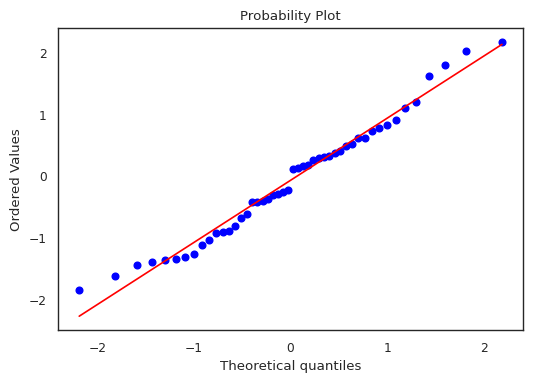

In [150]:
# your code here
fig, ax = plt.subplots(dpi=100)
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

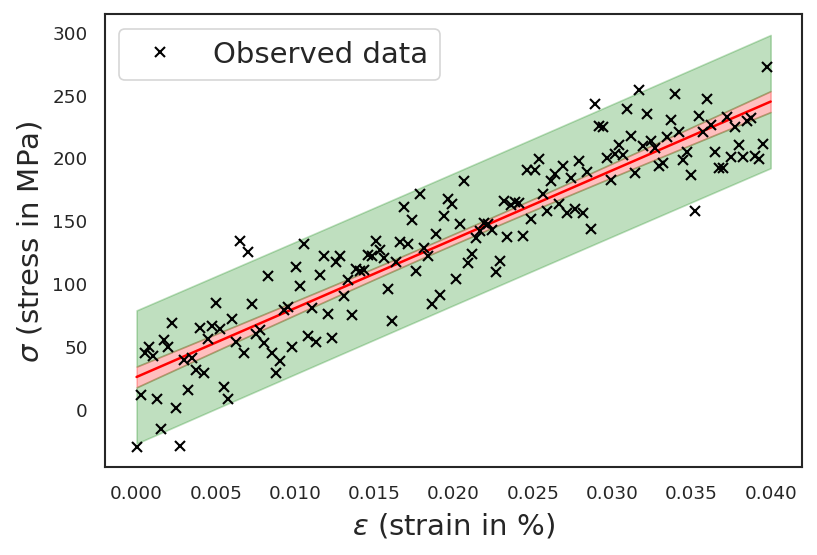

In [151]:
# your code here
sigma = np.sqrt(1.0 / model.alpha_)
xx = np.linspace(0, 0.04, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 1.96 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 1.96 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 1.96 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 1.96 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x_rel, y_rel, 'kx', label='Observed data')
# overlay the true 
ax.set_xlabel('$\epsilon$ (strain in %)', fontsize=14)
ax.set_ylabel('$\sigma$ (stress in MPa)', fontsize=14)
ax.legend(loc='best', fontsize = 14);

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

[  25.96302812 5467.94096873]
[[ 1.76765241e+01 -6.64544111e+02]
 [-6.64544111e+02  3.34356856e+04]]


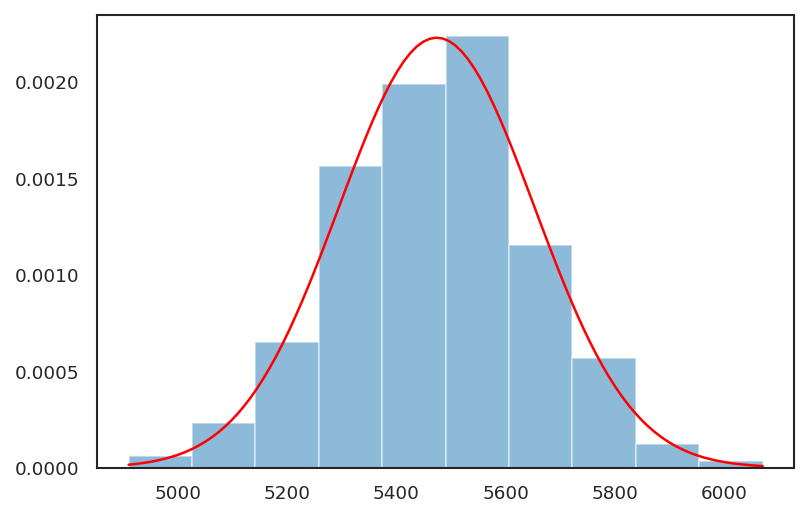

In [152]:
# your code here
import scipy.stats as st
num_samples=len(data)
# The posterior mean of the weights is here (this is for the normalized data, however)
m_norm = model.coef_
print(m_norm)
# The posterior covariance matrix for the weights is here (also for the normalized data)
S_norm = model.sigma_
print(S_norm)# First, let's get mean of the features as calculated inside the model

w_post = st.multivariate_normal(mean=m_norm, cov=S_norm)
w_sample = w_post.rvs(num_samples)
E_sample = w_sample[:,1]

fig, ax = plt.subplots(dpi=150)
ax.hist(E_sample, alpha=0.5, density=True, label='Histogram of Posterior E Samples')
ee = np.linspace(E_sample.min(), E_sample.max(), 100)
ee_norm=st.norm(np.mean(E_sample), np.std(E_sample))
ax.plot(ee, ee_norm.pdf(ee), 'r', label='Theoretical Posterior PDF');

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

Text(0, 0.5, '$\\sigma$ (stress in MPa)')

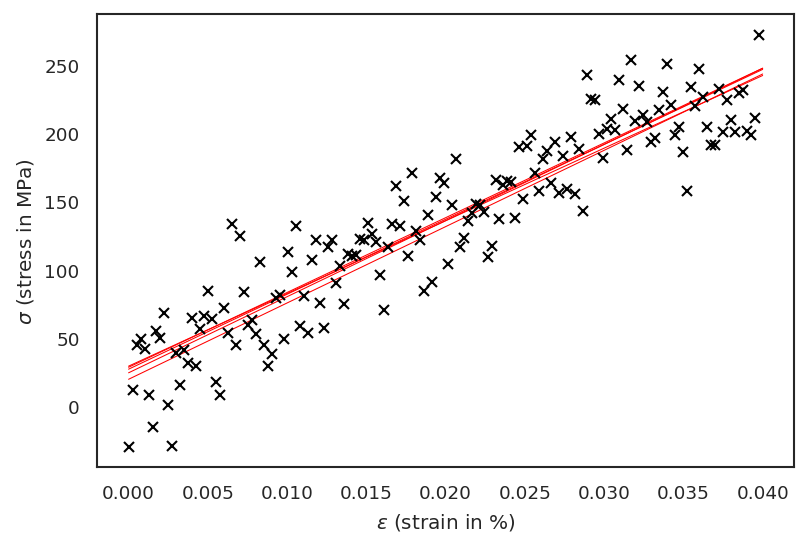

In [153]:
# your code here
xx=np.linspace(0,0.04,100)

Phi_xx=get_polynomial_design_matrix(xx[:,None], degree)

import scipy.stats as st
w_post=st.multivariate_normal(mean= m_norm, cov= S_norm)

fig, ax=plt.subplots(dpi=150)
for _ in range(5):
  w_sample=w_post.rvs()
  yy_sample=np.dot(Phi_xx, w_sample)
  ax.plot(xx, yy_sample, 'r', lw= 0.5)
ax.plot(x_rel, y_rel, 'kx', label= 'Observed Data')
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

E is in [5433.30, 5502.59] with 95% probability


Text(0.5, 1.0, '95% centered credible interval for E')

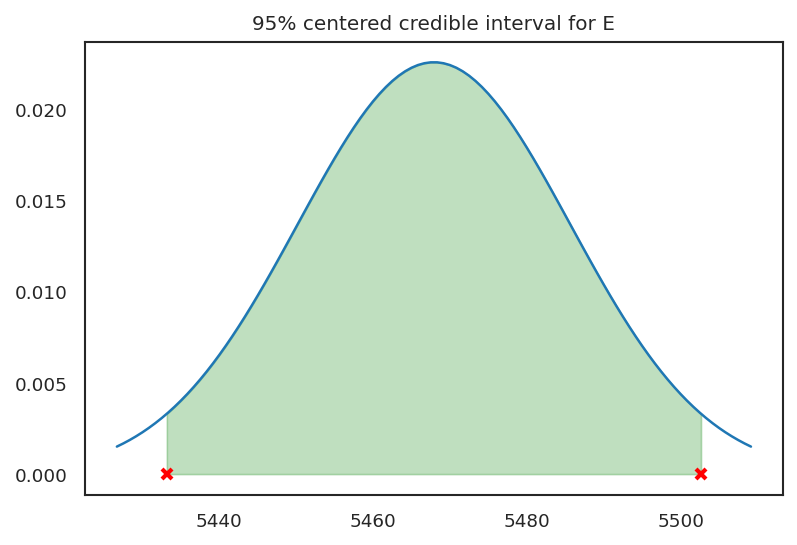

In [154]:
# your code here
# Write your code here and print() your answer

w_post=st.norm(loc=m_norm[1], scale= S_norm[0, 0])
w_low = w_post.ppf(0.025)
w_up = w_post.ppf(0.975)
w_s=np.linspace(w_post.ppf(0.01), w_post.ppf(0.99), 100)
w_int=np.linspace(w_low, w_up, 100)
print('E is in [{0:1.2f}, {1:1.2f}] with 95% probability'.format(w_low, w_up))

fig, ax = plt.subplots(dpi=150)
ax.plot(w_s, w_post.pdf(w_s))
ax.fill_between(w_int, np.zeros(w_int.shape), w_post.pdf(w_int), color='green', alpha=0.25)
ax.plot([w_low, w_up], np.zeros((2,)), 'x', color='red', markeredgewidth=2)
ax.set_title('95% centered credible interval for E')


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [155]:
# your code here
print('I would pick the Youngs modulus at the center (average)', w_post.ppf(0.5))

I would pick the Youngs modulus at the center (average) 5467.940968728071


*Your answer here*

## Part B - Estimate the yield stress

The pick of the stress-strain curve is known as the yield stress.
We will like to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [156]:
# your code here - Repeat as many text and code blocks as you like

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid=train_test_split(x, y, test_size=0.3)


Use the following to visualize your split:

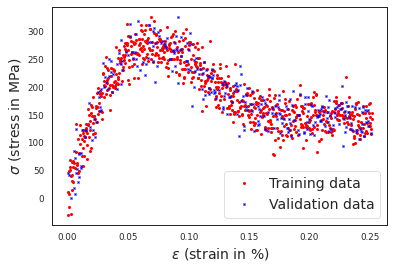

In [157]:
plt.figure()
plt.plot(x_train, y_train, 'ro', markersize=2, label = 'Training data')
plt.plot(x_valid, y_valid, 'bx', markersize=2, label = 'Validation data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model that can capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ it is linear in the parameters to be estimated,
+ it clearly has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We are goint to use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:
$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$
where
$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$
and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:
$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:
$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$
We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:
$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$
The reason we include the first derivative is so that we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:
$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$
We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:
$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$
We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other parameters.
I am going to spare you the details...
The end result is:
$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$
Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [158]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """
    Computes the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon
    for i in range(2, d+1):
        Phi[:, i-1] = [((i-1)*(epsilon_l)**i)-i*Epsilon*(epsilon_l)**(i-1)+Epsilon**i]*Step
    return Phi

Visualize the basis functions here:

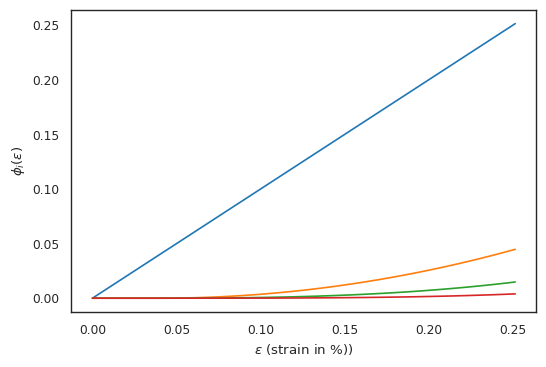

In [159]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$');

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing all the things we did above (MSE, observations vs predictions plot, standarized errors, etc.).

MSE_Valid= 743.801862688949


((array([-2.83376393, -2.53746473, -2.36970397, -2.2501598 , -2.15610747,
         -2.0779741 , -2.01078458, -1.95160864, -1.89856908, -1.85038814,
         -1.80615521, -1.76519756, -1.72700347, -1.69117434, -1.65739332,
         -1.62540424, -1.59499693, -1.56599668, -1.53825669, -1.51165232,
         -1.48607681, -1.46143801, -1.43765577, -1.41465996, -1.39238882,
         -1.37078766, -1.34980784, -1.32940587, -1.30954274, -1.29018324,
         -1.27129558, -1.25285087, -1.23482281, -1.21718739, -1.19992262,
         -1.18300828, -1.16642579, -1.15015798, -1.134189  , -1.11850412,
         -1.10308968, -1.08793299, -1.07302219, -1.05834621, -1.04389472,
         -1.02965801, -1.015627  , -1.00179313, -0.98814838, -0.97468516,
         -0.96139633, -0.94827515, -0.93531523, -0.92251053, -0.90985533,
         -0.89734419, -0.88497197, -0.87273374, -0.86062485, -0.84864086,
         -0.83677752, -0.8250308 , -0.81339683, -0.80187193, -0.79045256,
         -0.77913535, -0.76791706, -0.

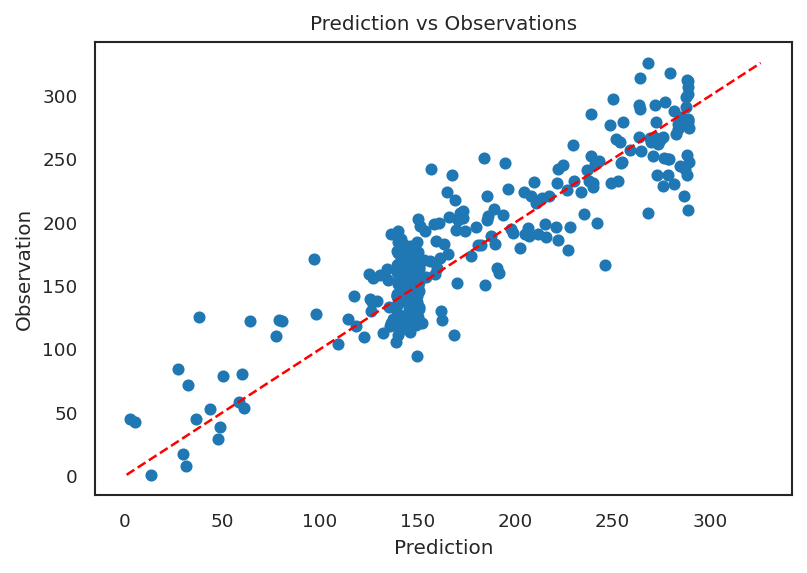

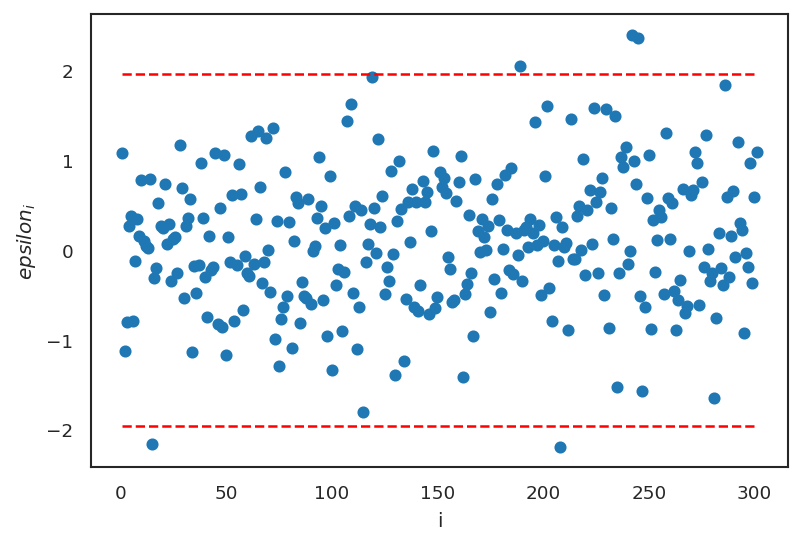

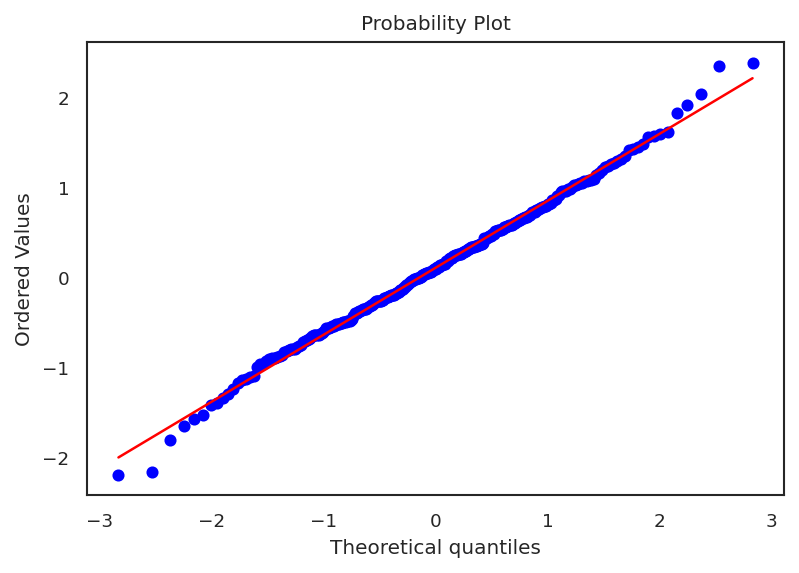

In [160]:
# Your code here - Use as many blocks as you need!
from sklearn.linear_model import ARDRegression
Phi = compute_design_matrix(x_train, epsilon_l, d)
model = ARDRegression(normalize=False, fit_intercept=False, threshold_lambda=np.inf).fit(Phi, y_train)
sigma=np.sqrt(1.0/model.alpha_)
alpha= model.lambda_
m_norm=model.coef_
S_norm=model.sigma_


Phi_valid=compute_design_matrix(x_valid, epsilon_l, d)
y_valid_predict, y_std= model.predict(Phi_valid, return_std=True)

MSE_valid=np.mean((y_valid_predict-y_valid)**2)
print('MSE_Valid=', MSE_valid)

fig, ax = plt.subplots(dpi=150)
ax.set_title('Prediction vs Observations')
ax.plot(y_valid_predict, y_valid, 'o')
yys=np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r--')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

eps = (y_valid-y_valid_predict)/y_std
idx=np.arange(1, eps.shape[0]+1)

fig, ax = plt.subplots(dpi=150)
ax.plot(idx, eps, 'o', label= 'Standardized Error')
ax.plot(idx, 1.96*np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96*np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('i')
ax.set_ylabel('$epsilon_i$')

fig, ax = plt.subplots(dpi = 150)
st.probplot(eps, dist=st.norm, plot=ax)

### Subpart B.IV
Visualize epistemic and aleatory uncertainty in the stess-strain relation.

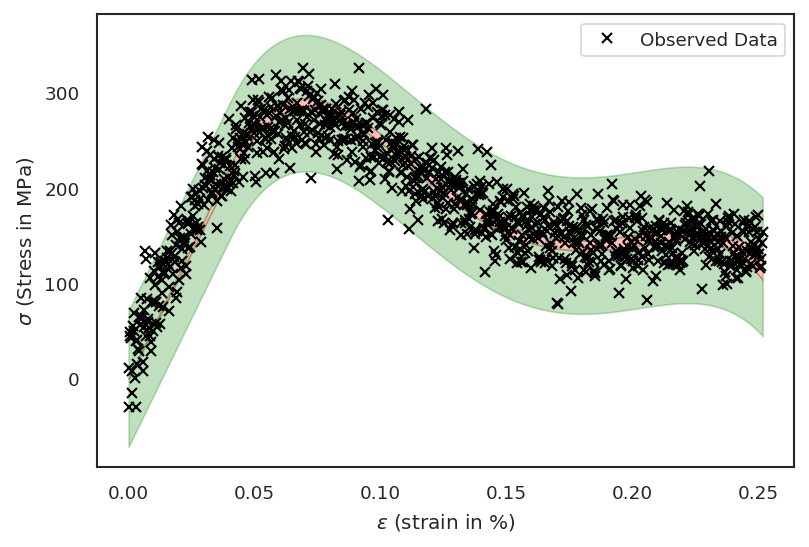

In [161]:
# Your code here
xx=np.linspace(0, x.max(), 1000)
Phi_xx=compute_design_matrix(xx, epsilon_l, d)
yy_mean, yy_measured_std=model.predict(Phi_xx, return_std=True)
yy_std=np.sqrt(yy_measured_std**2-sigma**2)
fig, ax= plt.subplots(dpi=150)

yy_le=yy_mean-1.96*yy_std
yy_ue=yy_mean+1.96*yy_std
yy_lae=yy_mean-1.96*yy_measured_std
yy_uae=yy_mean+1.96*yy_measured_std

ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color = 'green', alpha=0.25)

ax.plot(x, y, 'kx', label='Observed Data')
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (Stress in MPa)')
plt.legend(loc='best')

### Subpart B.V - Extract the yield stress

Now, you are going to quantify your epistemic uncertainty about the yield stress.
The yield stress is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the yield stress.

Do the following:
- Visualize posterior of the yield stress.
- Find a 95% credible interval for the yield stress.
- Pick a value for the yield stress.

**Hint:**
To characterize your epistemic uncertainty about the yield stress, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    + sample from the posterior of the weights of your model
    + for each sample evaluate the stresses at the dense set of strain points defined earlier
    + for each sampled stress vector, find the maximum. This is a sample of the yield stress.

[    5420.75485335  -239818.18456925  1107677.14380027 -1760453.92563894]
[[ 3.76678509e+03 -3.71011275e+05  2.00439233e+06 -3.59283229e+06]
 [-3.71011361e+05  5.75310526e+07 -3.35334931e+08  6.38661986e+08]
 [ 2.00439209e+06 -3.35334865e+08  1.97890315e+09 -3.80853661e+09]
 [-3.59283267e+06  6.38661963e+08 -3.80853699e+09  7.39785111e+09]]


/usr/local/lib/python3.6/dist-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Yield Stress Value= 288.91477967674797
E is in [283.68, 294.15] with 95% probability


Text(0.5, 1.0, '95% centered credible interval for E')

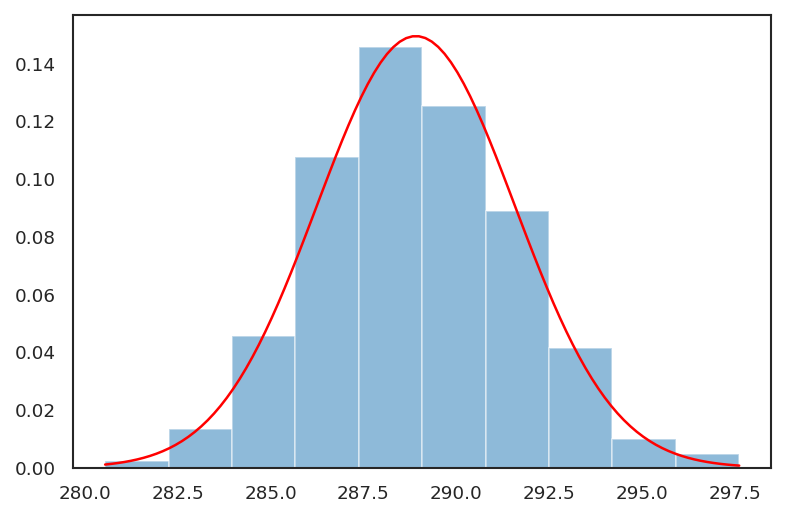

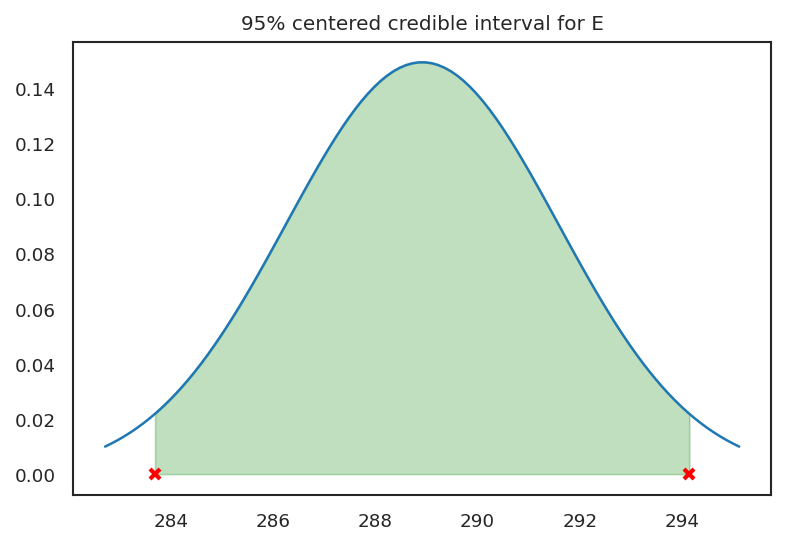

In [162]:

# your code here
# Write your code here and print() your answer

# your code here
import scipy.stats as st

# The posterior mean of the weights is here (this is for the normalized data, however)
m_norm = model.coef_
print(m_norm)
# The posterior covariance matrix for the weights is here (also for the normalized data)
S_norm = model.sigma_
print(S_norm)# First, let's get mean of the features as calculated inside the model

w_post = st.multivariate_normal(mean=m_norm, cov=S_norm + 1e-0 * np.eye(S_norm.shape[0]))
y_predict_max= np.ndarray((1000,))
for i in range(1000):
  w_sample = w_post.rvs(1)
  y_predict=np.dot(Phi_xx, w_sample)
  y_predict_max[i] =np.max(y_predict)

fig, ax = plt.subplots(dpi=150)
ax.hist(y_predict_max, alpha=0.5, density=True, label='Histogram of Posterior E Samples')
ee = np.linspace(y_predict_max.min(), y_predict_max.max(), 100)
ee_norm=st.norm(np.mean(y_predict_max), np.std(y_predict_max))
ax.plot(ee, ee_norm.pdf(ee), 'r', label='Theoretical Posterior PDF')


print('Yield Stress Value=', np.mean(y_predict_max))
# your code here
# Write your code here and print() your answer
from scipy.stats import norm
mu, std = norm.fit(y_predict_max)
y_predict_max_theo = st.norm( loc = mu, scale = std)

y_low = y_predict_max_theo.ppf(0.025)
y_up = y_predict_max_theo.ppf(0.975)
y_s=np.linspace(y_predict_max_theo.ppf(0.01), y_predict_max_theo.ppf(0.99), 100)
y_int=np.linspace(y_low, y_up, 100)


print('E is in [{0:1.2f}, {1:1.2f}] with 95% probability'.format(y_low, y_up))

fig, ax = plt.subplots(dpi=150)
ax.plot(y_s, y_predict_max_theo.pdf(y_s))
ax.fill_between(y_int, np.zeros(y_int.shape), y_predict_max_theo.pdf(y_int), color='green', alpha=0.25)
ax.plot([y_low, y_up], np.zeros((2,)), 'x', color='red', markeredgewidth=2)
ax.set_title('95% centered credible interval for E')


# Problem 2 - Optimizing the performance of a compressor

In this problem we are going to need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google drive or just download it with the code segment below:

In [163]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx'
download(url)

Note that this is an Excell file, so we are going to need pandas to read it.
Here is how:

In [ ]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

The data are part of a an experimental study of a variable speed reciprocating compressor.
The experimentalists varied two temperatures $T_e$ and $T_c$ (both in C) and they measured various other quantities.
Our goal is to learn the map between $T_e$ and $T_c$ and measured Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [ ]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
x

In [ ]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y


Fit the following multivariate polynomial model to **both the Capacity and the Power**:
$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$
where $\epsilon$ is a Gaussian noise term with unknown variance.
**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to make sure that your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

MSE= 978.734794609067
sigma= 57.43087583411729


((array([-1.8241636 , -1.38768012, -1.11829229, -0.91222575, -0.73908135,
         -0.5857176 , -0.44506467, -0.31273668, -0.18568928, -0.06158146,
          0.06158146,  0.18568928,  0.31273668,  0.44506467,  0.5857176 ,
          0.73908135,  0.91222575,  1.11829229,  1.38768012,  1.8241636 ]),
  array([-0.6899195 , -0.55243572, -0.17281985, -0.15942767, -0.12913396,
         -0.1024941 , -0.06034638,  0.00808014,  0.26103359,  0.34196821,
          0.37283583,  0.42772531,  0.46558245,  0.49421739,  0.56725585,
          0.63887276,  0.75695493,  0.77626792,  0.84003728,  0.87939045])),
 (0.4716987053968784, 0.2481822468300875, 0.9772908962620506))

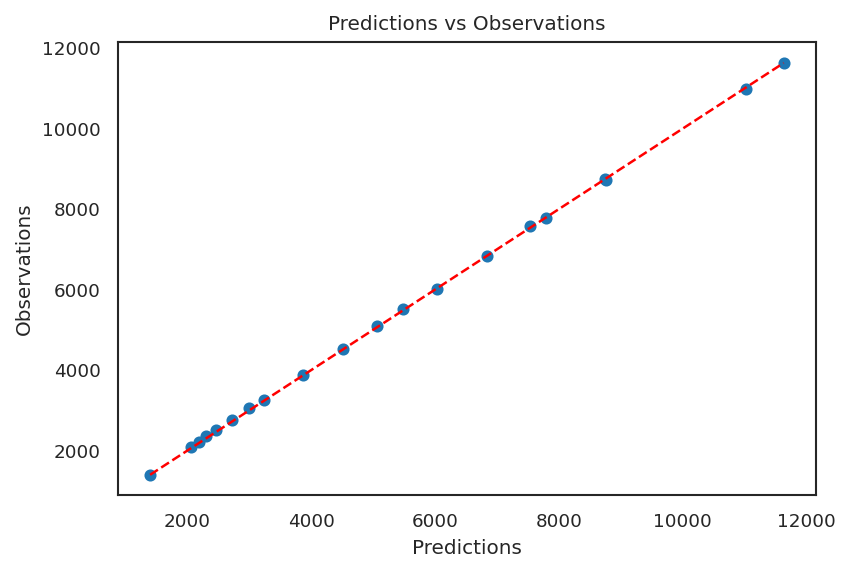

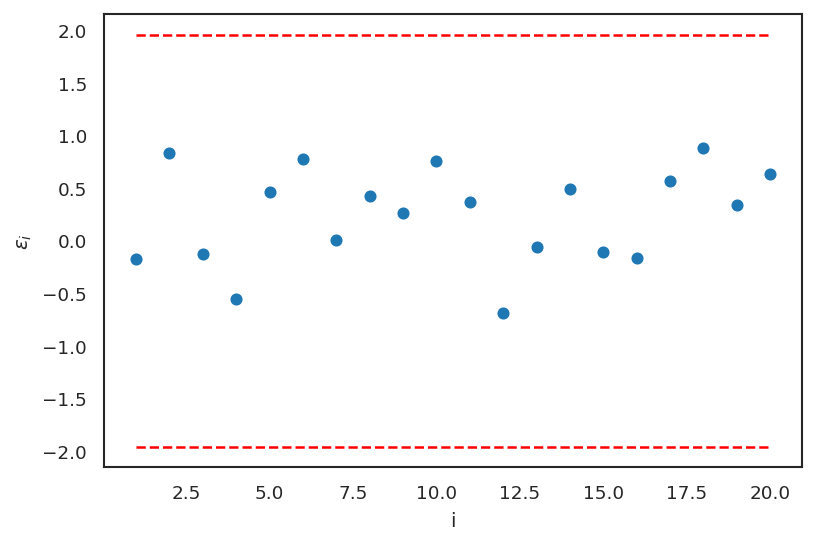

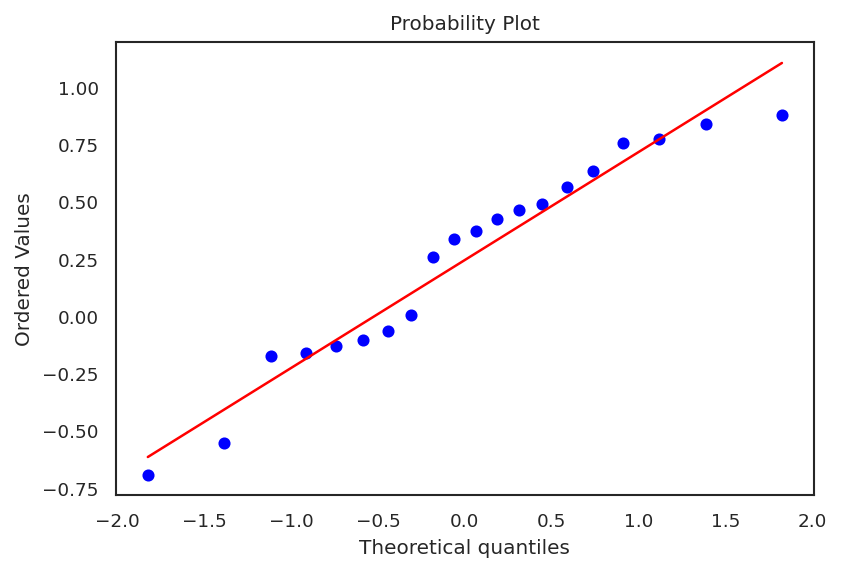

In [167]:
x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.3)

from sklearn.preprocessing import PolynomialFeatures
# Complete this code to make your model:
def compute_poly_feature_design_matrix(x, degree):
    """
    Computes the design matrix for the stress-strain curve problem.
    
    Arguments:
        x     -     A 1D array of dimension N.
        
        degree           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(x, np.ndarray)
    assert x.ndim == 2, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = x.shape[0]
    poly=PolynomialFeatures(degree)
    # Build the design matrix
    Phi = poly.fit_transform(x)
  
    return Phi


from sklearn.linear_model import ARDRegression
degree=3
Phi=compute_poly_feature_design_matrix(x, degree)
model=ARDRegression(normalize=False, fit_intercept=False).fit(Phi, y)

Phi_valid=compute_poly_feature_design_matrix(x_valid, degree)
y_valid_predict, y_std=model.predict(Phi_valid, return_std=True)
MSE_Valid=np.mean((y_valid_predict-y_valid)**2)
print('MSE=', MSE_Valid)

sigma=np.sqrt(1/model.alpha_)
print('sigma=', sigma)
alpha=model.lambda_
m_norm=model.coef_
S_norm=model.sigma_


#obervations vs predictions
fig, ax= plt.subplots(dpi=150)
ax.set_title('Predictions vs Observations')
ax.plot(y_valid_predict, y_valid, 'o')
yys=np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r--')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')


eps=(y_valid-y_valid_predict)/y_std
idx=np.arange(1, eps.shape[0]+1)
fig, ax=plt.subplots(dpi=150)
ax.plot(idx, eps, 'o', label='Standardized error')
ax.plot(idx, 1.96*np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96*np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('i')
ax.set_ylabel('$\epsilon_i$')

#quantile plot
fig, ax= plt.subplots(dpi=150)
st.probplot(eps, dist=st.norm, plot=ax)

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [168]:
sigma=np.sqrt(1/model.alpha_)
print('sigma=', sigma)

sigma= 57.43087583411729


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

[4.15610951e-09 3.20244579e-06 3.00595122e-05 2.67042865e-02
 1.79367527e-01 2.47287110e+01 4.69560162e+04 1.62306829e+03
 8.39525646e+02 1.88883924e+04]
Basis functions 0 through 5 are the most important features of the temperature


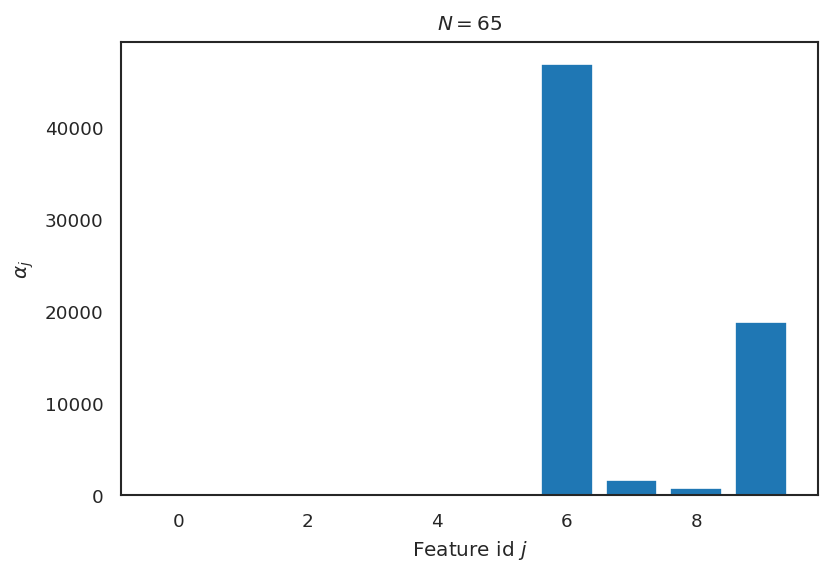

In [169]:
# Sklearn optimizes calls our alpha lambda_:
alpha = model.lambda_
num_obs = x.shape[0]

print(alpha)
fig, ax = plt.subplots(dpi=150)
ax.bar(np.arange(Phi.shape[1]), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(num_obs))

print('Basis functions 0 through 5 are the most important features of the temperature');

### Subpart B.I - Fit the Power

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

MSE= 764.9734921891611
sigma= 27.90532719622639


((array([-1.8241636 , -1.38768012, -1.11829229, -0.91222575, -0.73908135,
         -0.5857176 , -0.44506467, -0.31273668, -0.18568928, -0.06158146,
          0.06158146,  0.18568928,  0.31273668,  0.44506467,  0.5857176 ,
          0.73908135,  0.91222575,  1.11829229,  1.38768012,  1.8241636 ]),
  array([-1.14958215, -0.8527317 , -0.78204121, -0.77980187, -0.70508067,
         -0.69693902, -0.66821779, -0.58073433, -0.28572396, -0.25800678,
         -0.11764504, -0.02223514,  0.01506968,  0.09656691,  0.27707442,
          0.53064623,  0.72269168,  1.21282492,  1.77252331,  2.59857589])),
 (0.9433926170046403, 0.016361668117480674, 0.9344585571484019))

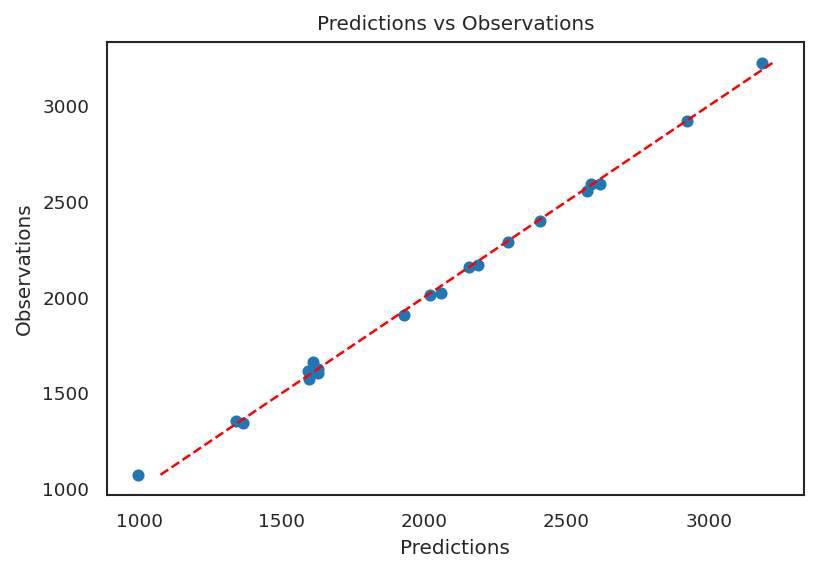

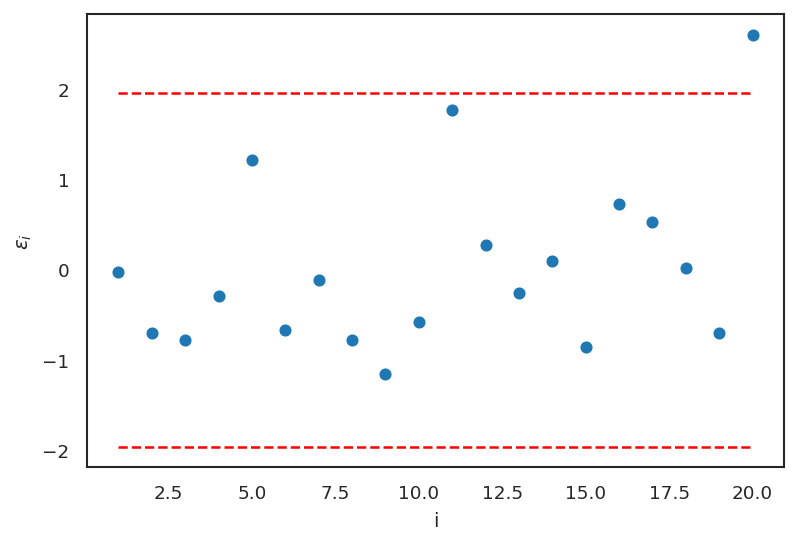

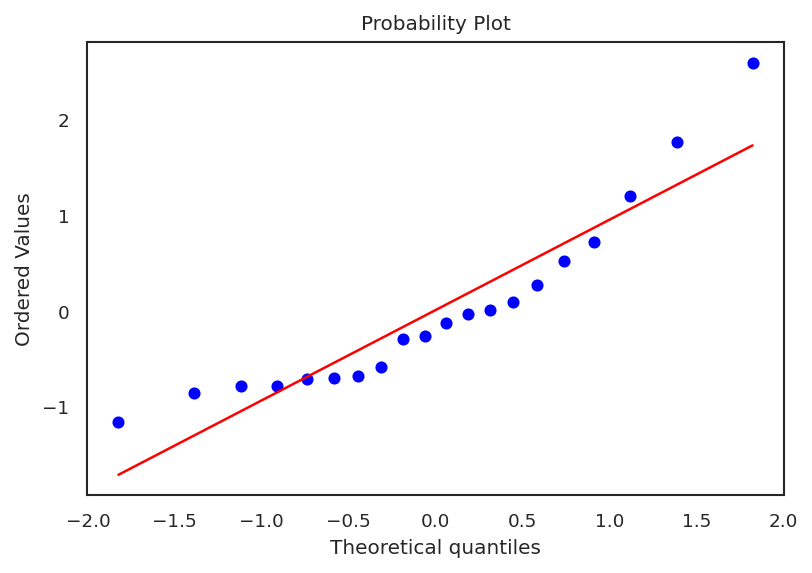

In [170]:
# your code here - Repeat as many text and code blocks as you like
y=data['Power'].values
x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.3)

from sklearn.preprocessing import PolynomialFeatures
# Complete this code to make your model:
def compute_poly_feature_design_matrix(x, degree):
    """
    Computes the design matrix for the stress-strain curve problem.
    
    Arguments:
        x     -     A 1D array of dimension N.
        
        degree           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(x, np.ndarray)
    assert x.ndim == 2, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = x.shape[0]
    poly=PolynomialFeatures(degree)
    # Build the design matrix
    Phi = poly.fit_transform(x)
  
    return Phi


from sklearn.linear_model import ARDRegression
degree=3
Phi=compute_poly_feature_design_matrix(x, degree)
model=ARDRegression(normalize=False, fit_intercept=False).fit(Phi, y)

Phi_valid=compute_poly_feature_design_matrix(x_valid, degree)
y_valid_predict, y_std=model.predict(Phi_valid, return_std=True)
MSE_Valid=np.mean((y_valid_predict-y_valid)**2)
print('MSE=', MSE_Valid)

sigma=np.sqrt(1/model.alpha_)
print('sigma=', sigma)
alpha=model.lambda_
m_norm=model.coef_
S_norm=model.sigma_


#obervations vs predictions
fig, ax= plt.subplots(dpi=150)
ax.set_title('Predictions vs Observations')
ax.plot(y_valid_predict, y_valid, 'o')
yys=np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r--')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')


eps=(y_valid-y_valid_predict)/y_std
idx=np.arange(1, eps.shape[0]+1)
fig, ax=plt.subplots(dpi=150)
ax.plot(idx, eps, 'o', label='Standardized error')
ax.plot(idx, 1.96*np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96*np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('i')
ax.set_ylabel('$\epsilon_i$')

#quantile plot
fig, ax= plt.subplots(dpi=150)
st.probplot(eps, dist=st.norm, plot=ax)

### Subpart B.II

What is the noise variance you estimated for the Power?

In [171]:
# your code here
sigma=np.sqrt(1/model.alpha_)
print('sigma=', sigma)

sigma= 27.90532719622639


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

[1.47940069e-05 5.04497884e-04 2.33502662e-04 1.47485955e+00
 3.52570277e-01 4.99274697e+00 3.06643192e+05 4.60304898e+05
 1.34443169e+04 4.58172597e+05]
Basis functions 0 through 5 are the most important features of the temperature


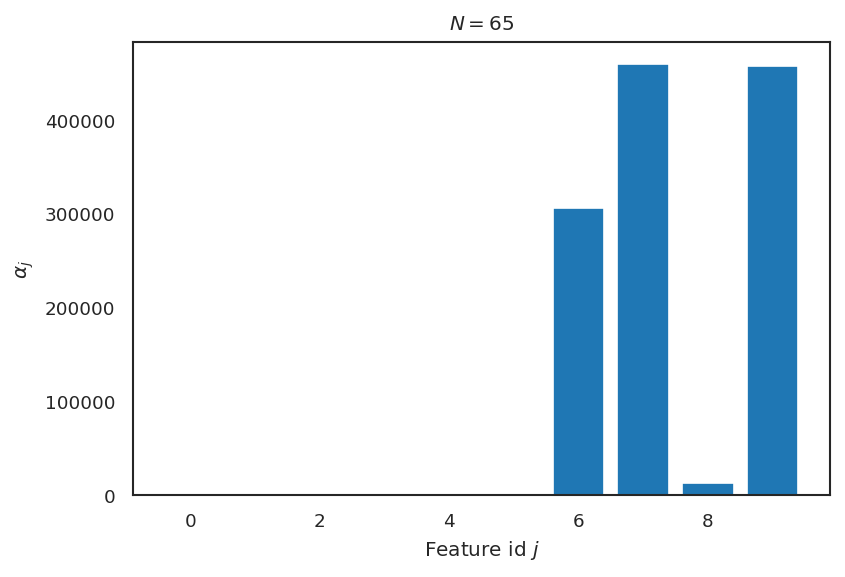

In [172]:
# your code here
# Sklearn optimizes calls our alpha lambda_:
alpha = model.lambda_
num_obs = x.shape[0]

print(alpha)
fig, ax = plt.subplots(dpi=150)
ax.bar(np.arange(Phi.shape[1]), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(num_obs))

print('Basis functions 0 through 5 are the most important features of the temperature');

# Problem 3 - Explaining the challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced on the rubber O-rings which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propelant through the nozzles thus producing thrust).

It turns out that the performance of the O-ring material was particularly sensitive on the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google drive or run the code cell below).

In [173]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv'
download(url)

Even though this is a csv file, you should load it with pandas because it contains some special characters.

In [ ]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` is has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We are going to use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before we proceed to the analysis of the data, let's clean the data up.

First, we drop all the bad records:

In [ ]:
clean_data_0 = raw_data.dropna()
clean_data_0

We also don't need the last record. Just remember that the temperature the day of the Challenger accident was 31 degrees F.

In [ ]:
clean_data = clean_data_0[:-1]
clean_data

Let's extract the features and the labels:

In [ ]:
x = clean_data['Temperature'].values
x

In [ ]:
y = clean_data['Damage Incident'].values.astype(np.float)
y

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Do not bother doing a validation because there are not a lot of data.
Just use a very simple model so that you don't overfit.

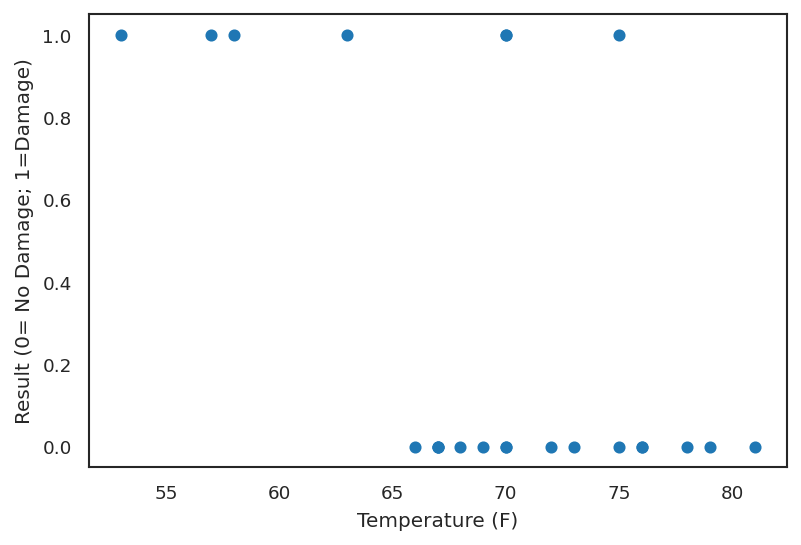

In [179]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.linear_model import LogisticRegression
# Make the design matrix
X = np.hstack([np.ones((x.shape[0], 1)), x[:, None]])
# Train the model (penalty = 'none' means that we do not add a prior on the weights)
# we are effectively just maximizing the likelihood of the data
model = LogisticRegression(penalty='none', fit_intercept=False).fit(X, y)

fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'o')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Result (0= No Damage; 1=Damage)');

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

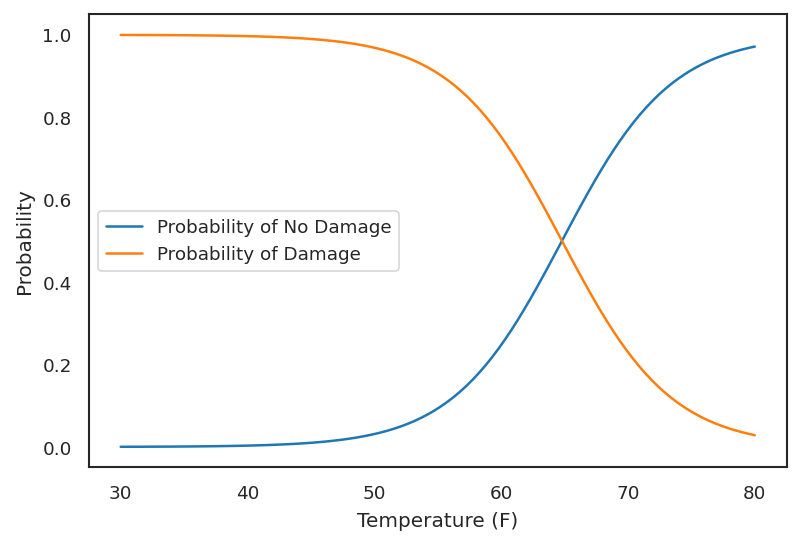

In [180]:
# your code here

fig, ax = plt.subplots(dpi=150)
xx = np.linspace(30,80,100)
XX = np.hstack([np.ones((xx.shape[0], 1)), xx[:, None]])
predictions_xx = model.predict_proba(XX)
ax.plot(xx, predictions_xx[:, 0], label='Probability of No Damage')
ax.plot(xx, predictions_xx[:, 1], label='Probability of Damage')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Probability')
plt.legend(loc='best');


## Part C - Decide whether or not to launch

The temperature the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

Probability= [0.0116222 0.9883778]


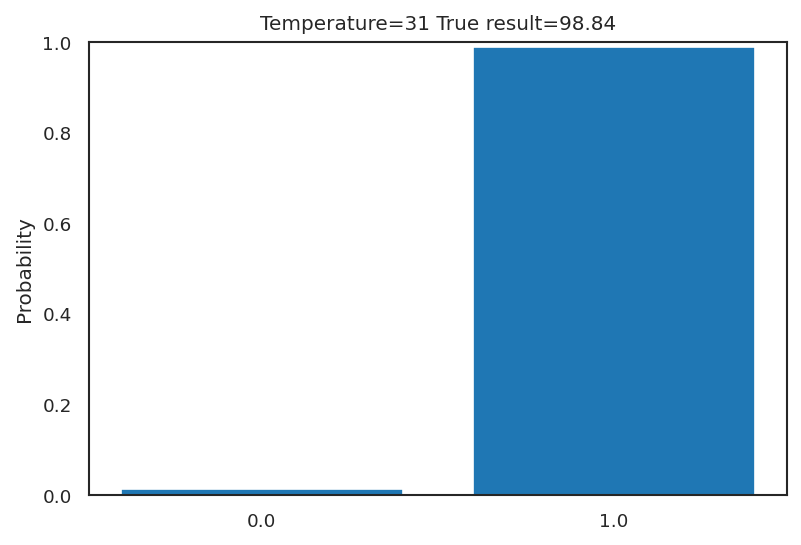

In [181]:
fig, ax= plt.subplots(dpi=150)
ax.bar(np.arange(2), predictions_xx[31])
ax.set_title('Temperature=31 True result=98.84')
ax.set_ylim([0, 1.0])
ax.set_xticks([0,1])
ax.set_xticklabels(model.classes_)
ax.set_ylabel('Probability')
print('Probability=', predictions_xx[31])


In [182]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
[[0.0, 10.0],
 [1.0, 0.0]]
)

In [183]:
def expected_cost(cost_matrix, prediction_prob):
    res = np.zeros((2,))
    for i in range(2):
        res[i] = cost_matrix[i, 0] * prediction_prob[0] + cost_matrix[i, 1] * prediction_prob[1]
    return res

In [184]:
print('x\tCost of 0\tCost of 1\tTrue label\tChoice')
print('-' * 80)
x_val = np.linspace(30, 80, 100)
for i in range(x.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions_xx[i])
    line = '{0:1.2f}\t{1:1.2f}'.format(x_val[i], exp_c[0])
    tmp = '\t\t{0:1.2f}'.format(exp_c[1])
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y[i] == 0:
            correct_choice = False
    line += tmp + '\t\t{0:d}'.format(int(y[i]))
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

x	Cost of 0	Cost of 1	True label	Choice
--------------------------------------------------------------------------------
30.00	10.00		0.00*		0		WRONG
30.51	10.00		0.00*		1		CORRECT
31.01	10.00		0.00*		0		WRONG
31.52	10.00		0.00*		0		WRONG
32.02	10.00		0.00*		0		WRONG
32.53	9.99		0.00*		0		WRONG
33.03	9.99		0.00*		0		WRONG
33.54	9.99		0.00*		0		WRONG
34.04	9.99		0.00*		1		CORRECT
34.55	9.99		0.00*		1		CORRECT
35.05	9.99		0.00*		1		CORRECT
35.56	9.99		0.00*		0		WRONG
36.06	9.99		0.00*		0		WRONG
36.57	9.99		0.00*		1		CORRECT
37.07	9.98		0.00*		0		WRONG
37.58	9.98		0.00*		0		WRONG
38.08	9.98		0.00*		0		WRONG
38.59	9.98		0.00*		0		WRONG
39.09	9.97		0.00*		0		WRONG
39.60	9.97		0.00*		0		WRONG
40.10	9.97		0.00*		1		CORRECT
40.61	9.96		0.00*		0		WRONG
41.11	9.96		0.00*		1		CORRECT


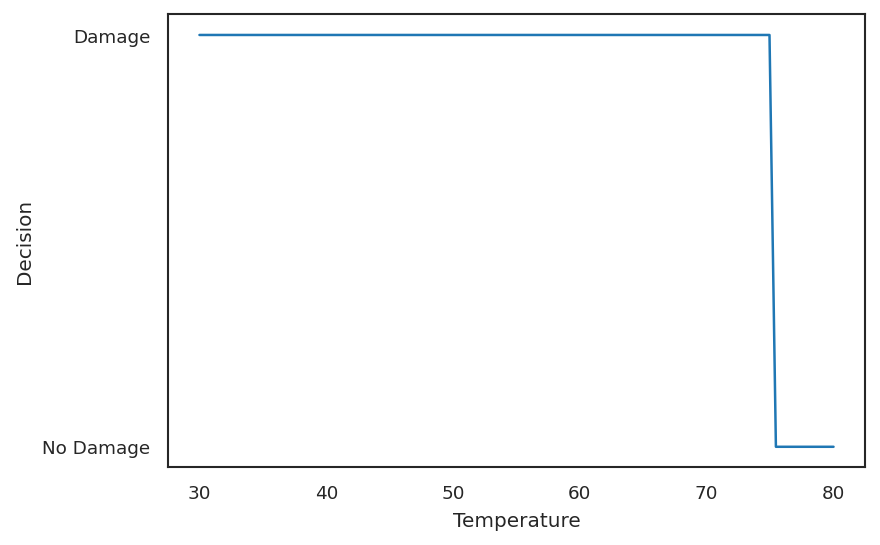

In [185]:
# Plot of decision boundary
fig, ax = plt.subplots(dpi=150)
pDamage = np.linspace(0, 1, 100)
pN = 1.0 - pDamage
probs = np.hstack([pDamage[:, None], pN[:, None]])
exp_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
decision_idx = np.argmin(exp_cost, axis=1)
ax.plot(xx, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Damage', 'Damage'])
ax.set_ylabel('Decision')
ax.set_xlabel('Temperature');